Plan-and-Execute
---

Execution agent:

In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(
    # max_results= 5
    # search_depth = "advanced"
    # include_domains = []
    # exclude_domains = []
    # include_answer = False
    # include_raw_content = False
    # include_images = False
)

In [21]:
tools = [TavilySearchResults(max_results=3)]
# tool.invoke("What is the weather in islamabad today?")

In [22]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview")
llm_with_tool = llm.bind_tools(tools)
llm_with_tool.invoke("What is weather today in islamabad?")
agent_executor = create_react_agent(llm_with_tool, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


/tmp/ipykernel_12862/2527652372.py:14: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.2.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm_with_tool, tools, messages_modifier=prompt)


In [23]:
agent_executor.invoke({"messages": [("user", "who is the winnner of fifa?")]})

{'messages': [HumanMessage(content='who is the winnner of fifa?', id='447c9964-1ae3-4b44-b694-8aefa554fbcf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dlBzDd683h3Dr8FC7ULU9Nl2', 'function': {'arguments': '{"query":"FIFA World Cup 2022 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 97, 'total_tokens': 122}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f7198062-4c0b-4e3c-825f-ffe47047427b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'FIFA World Cup 2022 winner'}, 'id': 'call_dlBzDd683h3Dr8FC7ULU9Nl2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 25, 'total_tokens': 122}),
  ToolMessage(content='[{"url": "https://www.npr.org/2022/12/18/1143933269/world-cup-final-argentina-france-messi-mbappe", "content": "Catherine Ivill/Get

Define state:

In [24]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: List[Tuple]
    response: str

Planning steps:

In [25]:
from langchain_core.pydantic_v1 import BaseModel, Field
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [26]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [27]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current winner of the Australia Open.', 'Find the hometown of the identified winner.'])

Re-plan step

In [33]:
from typing import Union
class Response(BaseModel):
    """ Response to user """
    response:str

class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

Create graph:

In [34]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [35]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

workflow.add_node("planner", plan_step)

workflow.add_node("agent", execute_step)

workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
)
app = workflow.compile()

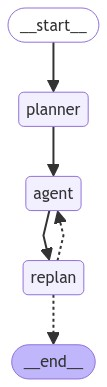

In [36]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [38]:
config = {"recursion_limit": 50}
inputs = {"input": "imran khan?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the context in which 'Imran Khan' is being referred to (e.g., cricketer, politician).", 'Gather relevant information about Imran Khan based on the identified context.', 'Summarize the gathered information to provide a concise answer.']}
{'past_steps': ("Identify the context in which 'Imran Khan' is being referred to (e.g., cricketer, politician).", "Based on the search results, Imran Khan is referred to in the context of being a politician, specifically a former Prime Minister of Pakistan. The articles discuss his political activities, including his arrest and charges of corruption, his party's (Pakistan Tehreek-e-Insaf) stance, and various aspects of his governance, such as foreign policy, economic ties, and anti-corruption efforts. Additionally, there is mention of Khan's past as a cricketer, highlighting his transition from sports to politics, but the primary context in the recent news and discussions is his role in politics.")}
{'plan': ['Gather relevant informa